``application_{train|test}.csv``
- Il s'agit de la table principale, divisée en deux fichiers pour Train (avec TARGET) et Test (sans TARGET).
- Données statiques pour toutes les applications. Une ligne représente un prêt dans notre échantillon de données.

``bureau.csv``
- Tous les crédits antérieurs du client fournis par d'autres institutions financières qui ont été signalés au bureau de crédit     (pour les clients qui ont un prêt dans notre échantillon).
- Pour chaque prêt de notre échantillon, il y a autant de lignes que le nombre de crédits que le client avait dans le Credit     
  Bureau avant la date de la demande.

``bureau_balance.csv``
- Soldes mensuels des crédits antérieurs au bureau de crédit.
- Ce tableau comporte une ligne pour chaque mois d'historique de chaque crédit précédent signalé au bureau de crédit - c'est-     à-dire que le tableau a (#prêts dans l'échantillon * # de crédits précédents relatifs * # de mois où nous avons un historique   observable pour les crédits précédents) lignes .

``POS_CASH_balance.csv``
- Instantanés mensuels du solde des points de vente précédents et des prêts en espèces que le demandeur avait contractés avec  Home Credit.
- Ce tableau a une ligne pour chaque mois d'historique de chaque crédit précédent dans Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon - c'est-à-dire que le tableau a (#prêts dans l'échantillon * # de crédits précédents relatifs * # de mois dans lequel nous avons un historique observable pour les lignes des crédits précédents).

``credit_card_balance.csv``
- Aperçus mensuels du solde des cartes de crédit précédentes que le demandeur a avec Home Credit.
- Ce tableau comporte une ligne pour chaque mois d'historique de chaque crédit précédent dans Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon - c'est-à-dire que le tableau a (#prêts dans l'échantillon * # de cartes de crédit précédentes relatives * # de mois où nous avons un historique observable pour la carte de crédit précédente) lignes.

``previous_application.csv``
- Toutes les demandes précédentes de prêts immobiliers des clients qui ont des prêts dans notre échantillon.
- Il y a une ligne pour chaque demande précédente liée aux prêts dans notre échantillon de données.

`installments_payments.csv``
- Historique de remboursement des crédits précédemment décaissés en Home Credit liés aux prêts de notre échantillon.
  Il y a a) une ligne pour chaque paiement effectué plus b) une ligne pour chaque paiement manqué.
- Une ligne équivaut à un versement d'une échéance OU une échéance correspondant à un versement d'un précédent crédit immobilier  lié aux prêts de notre échantillon.

``HomeCredit_columns_description.csv``
- Ce fichier contient les descriptions des colonnes des différents fichiers de données.


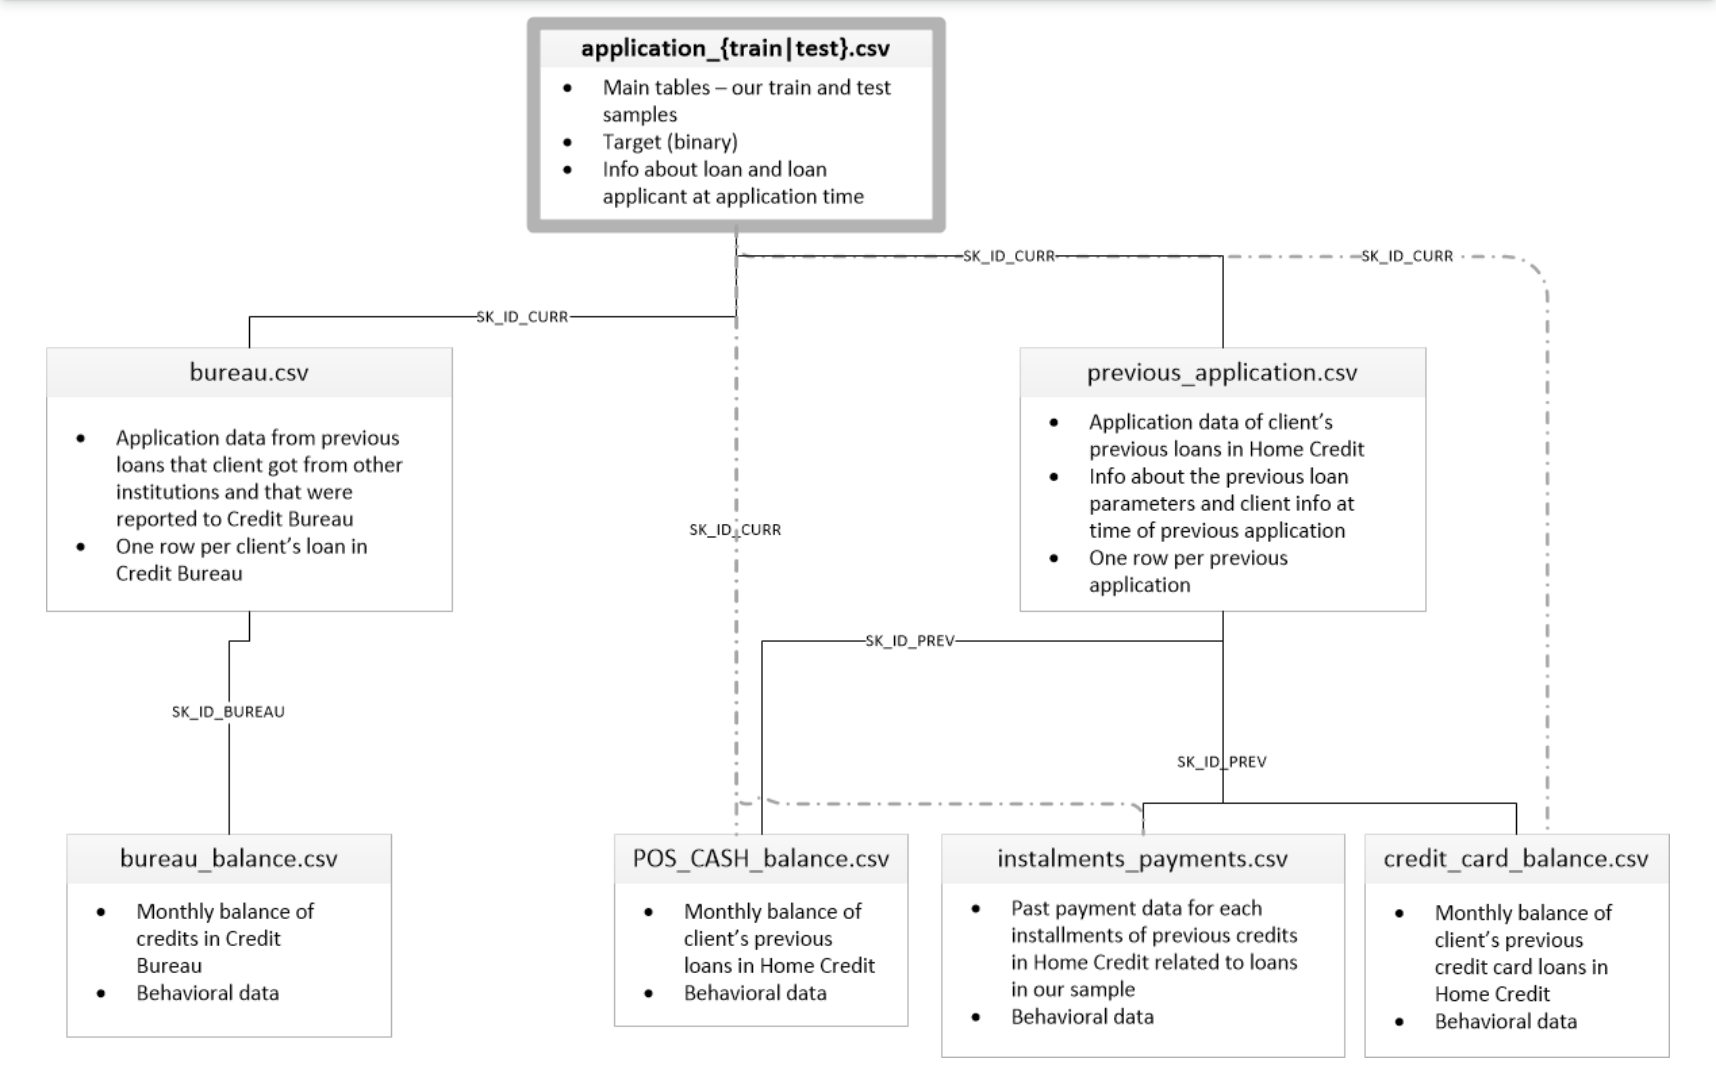

https://www.kaggle.com/c/home-credit-default-risk/data (lien de la data)

Inspiré du kernel : https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction/notebook
https://www.kaggle.com/code/danilz/merge-all-data-base-glm-vs-xgb-explained-0-763/notebook

In [1]:
pip install shap==0.28.0

  Using cached shap-0.28.0.tar.gz (221 kB)
Note: you may need to restart the kernel to use updated packages.


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\DEYTA\anaconda3\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\DEYTA\\AppData\\Local\\Temp\\pip-install-uwurjset\\shap_f86a30353ea442529be15efc8ccfaef0\\setup.py'"'"'; __file__='"'"'C:\\Users\\DEYTA\\AppData\\Local\\Temp\\pip-install-uwurjset\\shap_f86a30353ea442529be15efc8ccfaef0\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\DEYTA\AppData\Local\Temp\pip-wheel-jhwdnr5n'
       cwd: C:\Users\DEYTA\AppData\Local\Temp\pip-install-uwurjset\shap_f86a30353ea442529be15efc8ccfaef0\
  Complete output (55 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-3.9
  creating bui

  Running setup.py clean for shap
Failed to build shap
  Attempting uninstall: shap
    Found existing installation: shap 0.41.0
    Uninstalling shap-0.41.0:
      Successfully uninstalled shap-0.41.0
    Running setup.py install for shap: started
    Running setup.py install for shap: finished with status 'error'
  Rolling back uninstall of shap
  Moving to c:\users\deyta\anaconda3\lib\site-packages\shap-0.41.0.dist-info\
   from C:\Users\DEYTA\anaconda3\Lib\site-packages\~hap-0.41.0.dist-info
  Moving to c:\users\deyta\anaconda3\lib\site-packages\shap\
   from C:\Users\DEYTA\anaconda3\Lib\site-packages\~hap


In [1]:
import pandas as pd
import seaborn as sns
import time, pickle
import matplotlib.pyplot as plt
import numpy as np

#Preprocessing, Upsampling, Model Selection, Model Evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score 
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_predict, cross_val_score, learning_curve, cross_validate
#from sklearn.feature_selection import RFECV

import warnings
warnings.filterwarnings("ignore")

#Predictive Models
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import KFold, GridSearchCV

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [2]:
data = pd.read_csv ('data_df.csv')
test_df = pd.read_csv ('data_test.csv')
train_df = pd.read_csv ('data_train.csv')
TARGET = pd.read_csv ('TARGET.csv')


In [120]:
test_df.columns

Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       ...
       'HOUSETYPE_MODE_terraced house', 'WALLSMATERIAL_MODE_Block',
       'WALLSMATERIAL_MODE_Mixed', 'WALLSMATERIAL_MODE_Monolithic',
       'WALLSMATERIAL_MODE_Others', 'WALLSMATERIAL_MODE_Panel',
       'WALLSMATERIAL_MODE_Stone, brick', 'WALLSMATERIAL_MODE_Wooden',
       'EMERGENCYSTATE_MODE_No', 'EMERGENCYSTATE_MODE_Yes'],
      dtype='object', length=310)

In [3]:
data_test_T =  pd.read_csv ('data_test_T.csv')
data_train_T =  pd.read_csv ('data_train_T.csv')

In [4]:
data_test_T.head()

,Unnamed: 0,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_0,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,307511,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1,307512,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,307513,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,307514,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,307515,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [5]:
train_df = train_df.select_dtypes(include='int64').astype('int')
test_df = test_df.select_dtypes(include='int64').astype('int')


In [6]:
#del data['Unnamed: 0']
del train_df['Unnamed: 0']
del test_df['Unnamed: 0']
#del TARGET['Unnamed: 0']

In [7]:
del data_train_T['Unnamed: 0']
del data_test_T['Unnamed: 0']

In [8]:
del TARGET['Unnamed: 0']

In [9]:
print('Shape train:' ,train_df.shape )
print('Shape test :' ,test_df.shape )
print('Shape data :' ,data.shape )
print('Shape TARGET :' ,TARGET.shape )

Shape train: (307511, 310)
Shape test : (48744, 310)
Shape data : (356255, 194)
Shape TARGET : (307511, 1)


In [10]:
test_df.dtypes

SK_ID_CURR                         int32
NAME_CONTRACT_TYPE                 int32
FLAG_OWN_CAR                       int32
FLAG_OWN_REALTY                    int32
CNT_CHILDREN                       int32
                                   ...  
WALLSMATERIAL_MODE_Panel           int32
WALLSMATERIAL_MODE_Stone, brick    int32
WALLSMATERIAL_MODE_Wooden          int32
EMERGENCYSTATE_MODE_No             int32
EMERGENCYSTATE_MODE_Yes            int32
Length: 310, dtype: object

## Sépération du jeu d'entrainement en entrainement puis validation

In [11]:
X_train, X_test, y_train, y_test = train_test_split(train_df.values, TARGET.values, test_size=0.3, random_state=42)


## Oversampling Data Using SMOTE
### Equilibrage

In [12]:
print("Label 1, Before using SMOTE: {} ".format(sum(y_train==1)))
print("Label 0, Before using SMOTE: {} ".format(sum(y_train==0)))



Label 1, Before using SMOTE: [17412] 
Label 0, Before using SMOTE: [197845] 


In [13]:
%%time
sm = SMOTE(random_state=0)
X_train, y_train = sm.fit_resample(X_train, y_train)

Wall time: 18.9 s


In [14]:
print("Label 1, After using SMOTE: {}".format(sum(y_train==1)))
print("Label 0, After using SMOTE: {}".format(sum(y_train==0)))

Label 1, After using SMOTE: 197845
Label 0, After using SMOTE: 197845


### Les Modeles de predictions

- Light Gradient Boosted Machine (LightGBM) est une bibliothèque open source qui fournit une implémentation efficace et efficiente de l'algorithme d'amplification de gradient.LightGBM est un algorithme  d'apprentissage automatique pour la modélisation prédictive de régression et de classification.

L'élimination récursive de caractéristiques (RFE) est une méthode de sélection de caractéristiques qui adapte un modèle et supprime la caractéristique (ou les caractéristiques) la plus faible jusqu'à ce que le nombre spécifié de caractéristiques soit atteint. Les entités sont classées par les attributs coef_ ou feature_importances_ du modèle, et en éliminant de manière récursive un petit nombre d'entités par boucle, RFE tente d'éliminer les dépendances et la colinéarité qui peuvent exister dans le modèle.

## B. Modelisation sans Grid Search 
### 1. Liste des classifieurs 

In [16]:
  models = [
          #Ensemble methods
          DummyClassifier(),
          LogisticRegression(),
          RandomForestClassifier(),
          LGBMClassifier(),
          XGBClassifier()
          ]


In [17]:
def train_models(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    output = {
      'AUC': roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),
      'Accuracy': accuracy_score(y_test, model.predict(X_test)),
      'Precision': precision_score(y_test, model.predict(X_test)),
      'Recall': recall_score(y_test, model.predict(X_test)),
      'F1': f1_score(y_test, model.predict(X_test))
      }
          
    return output

In [18]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models:
    start = time.time()
    results = train_models(model, X_train, X_test, y_train, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

#Initialise data of lists
base_models = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
base_models.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
base_models.sort_values('AUC', ascending=False, inplace=True)



Wall time: 7min 5s


In [19]:
base_models

,Model,AUC,Accuracy,Precision,Recall,F1,Time
2,RandomForestClassifier,0.582835,0.867594,0.112242,0.093754,0.102168,197.695823
3,LGBMClassifier,0.57899,0.878932,0.125747,0.085121,0.10152,8.977681
4,XGBClassifier,0.575312,0.864656,0.125609,0.114798,0.119961,203.620318
1,LogisticRegression,0.570089,0.892937,0.124161,0.054904,0.076139,14.684355
0,DummyClassifier,0.5,0.919646,0.0,0.0,0.0,0.117564


-  Sans appliquer la selection du meuilleur hyperparametre ``RandomForestClassifie`` est le meuilleur modèle en terme de AUC

In [20]:
base_model_index = base_models.copy()

In [21]:
base_model_index.set_index('Model', inplace = True)

In [22]:
#base_model_index

L'aire sous la courbe ROC (ou Area Under the Curve, AUC) peut être interprétée comme la probabilité que, parmi deux sujets choisis au hasard, non solvable et un solvable, la valeur du marqueur soit plus élevée pour le non solvable que pour le solvable. Par conséquent, une AUC de 0,5 (50%) indique que le marqueur est non-informatif. Une augmentation de l'AUC indique une amélioration des capacités discriminatoires, avec un maximum de 1,0 (100%).

Text(0.5, 1.0, 'Metrique : Precision')

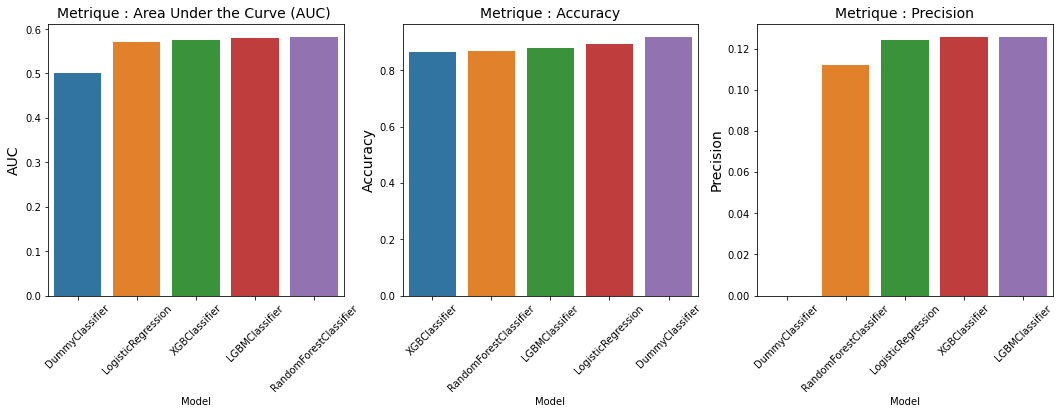

In [23]:
fig = plt.figure(1, figsize=(18, 5))

plt.subplot(131)
base_model_index = base_model_index.sort_values(by=['AUC'])
sns.barplot(x = base_model_index.index,y = base_model_index["AUC"])
plt.xticks(rotation=45,fontsize=10)
plt.ylabel("AUC",fontsize=14)
plt.title("Metrique : Area Under the Curve (AUC) ", fontsize=14)


plt.subplot(132)
base_model_index = base_model_index.sort_values(by=['Accuracy'])
sns.barplot(x = base_model_index.index,y = base_model_index["Accuracy"])
plt.xticks(rotation=45,fontsize=10)
plt.ylabel("Accuracy",fontsize=14)
plt.title("Metrique : Accuracy", fontsize=14)

plt.subplot(133)
base_model_index = base_model_index.sort_values(by=['Precision'])
sns.barplot(x = base_model_index.index,y = base_model_index["Precision"])
plt.xticks(rotation=45,fontsize=10)
plt.ylabel("Precision",fontsize=14)
plt.title("Metrique : Precision", fontsize=14)

Text(0.5, 1.0, 'Le temps: Time')

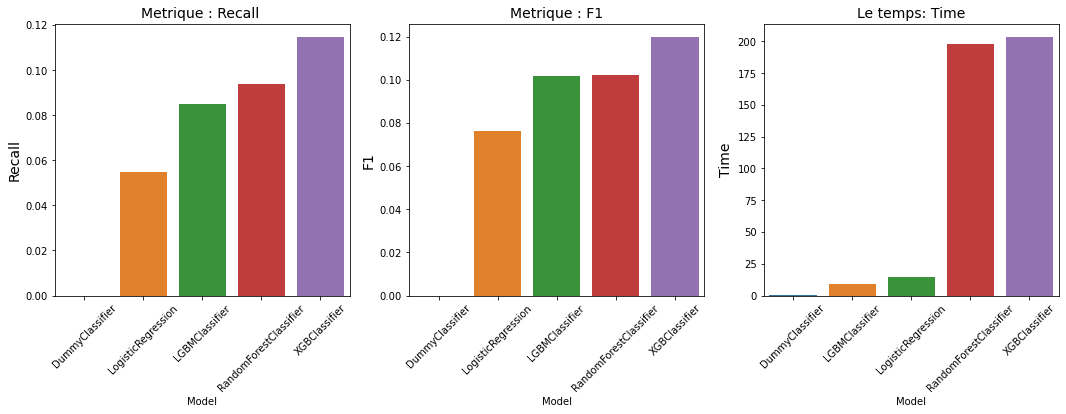

In [24]:
fig = plt.figure(1, figsize=(18, 5))

plt.subplot(131)
base_model_index = base_model_index.sort_values(by=['Recall'])
sns.barplot(x = base_model_index.index,y = base_model_index["Recall"])
plt.xticks(rotation=45,fontsize=10)
plt.ylabel("Recall",fontsize=14)
plt.title("Metrique : Recall ", fontsize=14)


plt.subplot(132)
base_model_index = base_model_index.sort_values(by=['F1'])
sns.barplot(x = base_model_index.index,y = base_model_index["F1"])
plt.xticks(rotation=45,fontsize=10)
plt.ylabel("F1",fontsize=14)
plt.title("Metrique : F1", fontsize=14)


plt.subplot(133)
base_model_index = base_model_index.sort_values(by=['Time'])
sns.barplot(x = base_model_index.index,y = base_model_index["Time"])
plt.xticks(rotation=45,fontsize=10)
plt.ylabel("Time",fontsize=14)
plt.title("Le temps: Time", fontsize=14)

## Modelisation avec Grid Search 
### Hyperparameters tunning 

In [25]:
kfold = StratifiedKFold(n_splits=5, random_state=100, shuffle=True)

def cross_validation(x, y, model):
    result= cross_val_score(model, x, y, cv=kfold, scoring="roc_auc", n_jobs=-1)
    print("Score: %f" % result.mean())

In [26]:
def RndSrch_Tune(model, X, y, params):
    
    clf = RandomizedSearchCV(model, params, scoring ='roc_auc', cv = kfold, n_jobs=-1, random_state=100)
    clf.fit(X, y)
    print("Le meilleur score est :" , clf.best_score_)
    print("Le meilleur estimateur est :" , clf.best_estimator_)
    print("Le meilleur paramètre est :" , clf.best_params_)
    return (clf.best_score_)

### Entrainement du modèle  sur le jeu d'entrainement ``X_train`` et ``y_train``
### Selection du meilleur hyperparamètre

Dans cette partie je vais chercher le meuilleur hyperparametre de tout les algorithme et le calcul du meuilleur score 

### LGBMClassifier

In [27]:
# Value of hyperparameters for random search

param_lgb = {'learning_rate':[0.2,0.1,0.01,0.05,0.001],
              'num_leaves':range(10,100,10),
              'min_child_samples':range(500,1000,100),
              'reg_alpha':[0.1,0.01,0.2,0.3],
              'reg_lambda':[0.1,0.01,0.2,0.3],
             'n_estimators':range(50,300,50),
              'max_bin': range(500,1500,100)}

RndSrch_Tune(LGBMClassifier(random_state = 100, n_jobs=-1, class_weight = 'balanced'), 
              X_train, y_train, param_lgb)

Le meilleur score est : 0.9510936138147097
Le meilleur estimateur est : LGBMClassifier(class_weight='balanced', learning_rate=0.2, max_bin=1000,
               min_child_samples=800, n_estimators=150, num_leaves=60,
               random_state=100, reg_alpha=0.01, reg_lambda=0.01)
Le meilleur paramètre est : {'reg_lambda': 0.01, 'reg_alpha': 0.01, 'num_leaves': 60, 'n_estimators': 150, 'min_child_samples': 800, 'max_bin': 1000, 'learning_rate': 0.2}


0.9510936138147097

In [28]:
lgb =   LGBMClassifier(**{'class_weight' : 'balanced',
                        'learning_rate' : 0.2,
                        'max_bin' : 1000,
                        'min_child_samples' : 800,
                        'n_estimators' : 150,
                        'num_leaves' : 60,
                         'random_state' : 100,
                        'reg_alpha' : 0.01,
                        'reg_lambda' : 0.01} )
scores_lgb = cross_validation(X_train, y_train, lgb)
print(scores_lgb)


Score: 0.951094
None


 le meuilleur score avec cross_validation pour l'algorithme LGMClassifier = 0.95

In [29]:
lgb.fit(X_train, y_train)
roc_auc = roc_auc_score(y_test, lgb.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, lgb.predict(X_test)))

AUC : 0.5726
              precision    recall  f1-score   support

         0.0       0.92      0.94      0.93     84841
         1.0       0.10      0.07      0.09      7413

    accuracy                           0.87     92254
   macro avg       0.51      0.51      0.51     92254
weighted avg       0.86      0.87      0.86     92254



### XGBClassifier

In [30]:
counter = Counter(y_train)
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 1.000


In [ ]:
# Value of hyperparameters for random search

param_xgbc = {'learning_rate':[0.2,0.1,0.01,0.05,0.001],
              'subsample':[1,0.5,0.2,0.1],
              'max_depth' : range(2,11,1),
              'n_estimators':range(50,300,50)}

RndSrch_Tune(XGBClassifier(random_state = 100, n_jobs=-1, scale_pos_weight=estimate), 
              X_train, y_train, param_xgbc)

In [ ]:
xgbc = XGBClassifier(**{'subsample': 0.1,
                        'n_estimators': 250, 
                        'max_depth': 5,
                        'learning_rate': 0.1
                        })

scores_xgbc = cross_validation(X_train, y_train, xgbc)
print(scores_xgbc)

In [ ]:
xgbc.fit(X_train, y_train)
roc_auc = roc_auc_score(y_test, xgbc.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, xgbc.predict(X_test)))

### LogisticRegression

In [ ]:
# Value of hyperparameters for random search

param_clr = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}

RndSrch_Tune(LogisticRegression(C = 0.0001, max_iter=100), X_train, y_train, param_clr)

In [ ]:
clr = LogisticRegression(**{'penalty': 'l2', 'C': 10.0})

scores_clr = cross_validation(X_train, y_train, clr)
print(scores_clr)

In [ ]:
clr.fit(X_train, y_train)
roc_auc = roc_auc_score(y_test, clr.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, clr.predict(X_test)))

 le meuilleur score avec cross_validation pour l'algorithme LogisticRegression = 0.94

### RandomForestClassifier

In [ ]:
# Value of hyperparameters for random search

param_rdc = {'n_estimators': [200, 500],
             'max_features': ['auto', 'sqrt', 'log2'],
             'max_depth' : [4,5,6,7,8],
             'criterion' :['gini', 'entropy']}

RndSrch_Tune(RandomForestClassifier(random_state=42), X_train, y_train, param_rdc)



In [ ]:
rdc = RandomForestClassifier(**{'n_estimators': 500, 
                                'max_features': 'log2', 
                                'max_depth': 8,
                                'criterion': 'entropy'})

scores_rdc = cross_validation(X_train, y_train, rdc)
print(scores_rdc)

In [ ]:
rdc.fit(X_train, y_train)
roc_auc = roc_auc_score(y_test, rdc.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, rdc.predict(X_test)))

 le meuilleur score avec cross_validation pour l'algorithme RandomForestClassifier = 0.79

### DummyClassifier

In [ ]:
# Value of hyperparameters for random search

param_dummyc = { 'strategy':["most_frequent", "prior", "uniform"]}

RndSrch_Tune(DummyClassifier(), X_train, y_train, param_dummyc)



In [ ]:
dummyc  = DummyClassifier(**{'strategy': 'most_frequent'})

scores_dummyc = cross_validation(X_train, y_train, dummyc)
print(scores_dummyc)

In [ ]:
dummyc.fit(X_train, y_train)
roc_auc = roc_auc_score(y_test, dummyc.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, dummyc.predict(X_test)))

 le meuilleur score avec cross_validation pour l'algorithme DummyClassifier = 0.5

### Selection des hyperparamètre de tout les metriques

In [ ]:
  models_gridseach = [
          #Ensemble methods
          DummyClassifier(**{'strategy': 'most_frequent'}),
          LogisticRegression(**{'penalty': 'l2', 'C': 10.0}),
          RandomForestClassifier(**{'n_estimators': 500, 
                                'max_features': 'log2', 
                                'max_depth': 8,
                                'criterion': 'entropy'}),
          LGBMClassifier(**{'class_weight' : 'balanced',
                        'learning_rate' : 0.2,
                        'max_bin' : 1000,
                        'min_child_samples' : 800,
                        'n_estimators' : 150,
                        'num_leaves' : 60,
                         'random_state' : 100,
                        'reg_alpha' : 0.01,
                        'reg_lambda' : 0.01} ),
          XGBClassifier(**{'subsample': 0.1,
                        'n_estimators': 250, 
                        'max_depth': 5,
                        'learning_rate': 0.1})
          ]


In [ ]:
#%%time

#name = []
#auc = []
#accuracy = []
#precision = []
#recall = []
#f1 = []
#time_ = []

#for model in models_gridseach:
 #   start = time.time()
#    results = train_models(model, X_train, X_test, y_train, y_test)

#    name.append(type(model).__name__)
#    auc.append(results['AUC'])
#    accuracy.append(results['Accuracy'])
 #   precision.append(results['Precision'])
 #   recall.append(results['Recall'])
#    f1.append(results['F1'])
#    time_.append(time.time()-start)

#Initialise data of lists
#base_models_gridsearch = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
#base_models_gridsearch.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
#base_models_gridsearch.sort_values('AUC', ascending=False, inplace=True)


In [ ]:
#base_models_gridsearch

In [ ]:
#base_models_gridsearch_index = base_models_gridsearch.copy()

In [ ]:
#base_models_gridsearch_index.set_index('Model', inplace = True)

In [ ]:
#base_models_gridsearch_index

Le modèle est bon dès lors que la valeur de l'AUC est supérieure à 0.7.
Un modèle bien discriminant doit avoir une AUC entre 0.87 et 0.9. 
Un modèle ayant une AUC supérieure à 0.9 est excellent
Dans nombre notre cas le meuilleur modèle parmi les autres est: ``RandomForestClassifier`` avec une valeur AUC = 0.6 (modèle moyennement bon


L'accuracy est une métrique de performance qui évalue la capacité d'un modèle de classification à bien prédire à la fois les individus positifs et les individus négatifs.
L’indicateur le plus simple est l’accuracy : il indique le pourcentage de bonnes prédictions. C’est un très bon indicateur parce qu’il est très simple à comprendre.

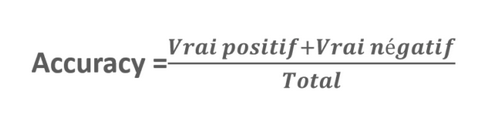

Pour compléter l’accuracy, on calcule également le recall : il se concentre uniquement sur les clients qui ont réellement résilié et donne une indication sur la part de faux négatifs. Les faux négatifs ce sont les clients qui résilient mais qui ne sont pas détectés par le score. Concrètement ce sont des clients que vous ne détectez pas et pour lesquels vous ne pourrez pas agir pour éviter leur départ.

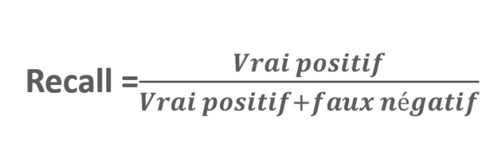

Enfin, un 3ème indicateur vient compléter l’accuracy et le recall, c’est la precision : il se concentre uniquement sur les clients pour lesquels le modèle a prédit une résiliation et donne une indication sur les faux positifs. Les faux positifs ce sont les clients pour lesquels le score a prédit une résiliation mais qui sont restés abonnés. C’est à dire que pour ces clients, vous engagerez surement des actions marketing pour les fidéliser mais ces actions n’étaient pas nécessaires puisqu’ils n’allaient pas résilier. Il faut limiter les faux positifs pour réduire le coût des campagnes.

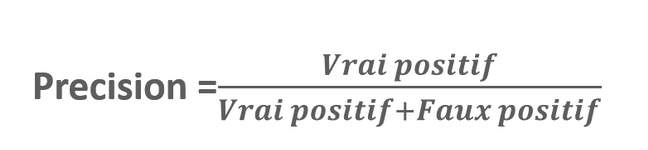

La matrice de confusion à elle seule donne des informations vraiment intéressantes. On peut identifier quelles sont les forces et les faiblesses de nos algorithmes.

L’accuracy, le recall et la precision sont à utiliser ensemble pour donner une vision complète de la performance. On cherche à avoir des valeurs le plus proche possible de 100% pour les 3 indicateurs. Selon les cas, on choisira parfois de maximiser le recall plutôt que la precision ou vice versa. Cela dépend du projet. 

In [ ]:
#fig = plt.figure(1, figsize=(18, 5))

#plt.subplot(131)
#base_models_gridsearch_index = base_models_gridsearch_index.sort_values(by=['AUC'])
#sns.barplot(x = base_models_gridsearch_index.index,y = base_models_gridsearch_index["AUC"])
#plt.xticks(rotation=45,fontsize=10)
#plt.ylabel("AUC",fontsize=14)
#plt.title("Metrique : Area Under the Curve (AUC) ", fontsize=14)


#plt.subplot(132)
#base_models_gridsearch_index = base_models_gridsearch_index.sort_values(by=['Accuracy'])
#sns.barplot(x = base_models_gridsearch_index.index,y = base_models_gridsearch_index["Accuracy"])
#plt.xticks(rotation=45,fontsize=10)
#plt.ylabel("Accuracy",fontsize=14)
#plt.title("Metrique : Accuracy", fontsize=14)

#plt.subplot(133)
#base_models_gridsearch_index = base_models_gridsearch_index.sort_values(by=['Precision'])
#sns.barplot(x = base_models_gridsearch_index.index,y = base_models_gridsearch_index["Precision"])
#plt.xticks(rotation=45,fontsize=10)
#plt.ylabel("Precision",fontsize=14)
#plt.title("Metrique : Precision", fontsize=14)

In [ ]:
#fig = plt.figure(1, figsize=(18, 5))#

#plt.subplot(131)
#base_models_gridsearch_index = base_models_gridsearch_index.sort_values(by=['Recall'])
#sns.barplot(x = base_models_gridsearch_index.index,y = base_models_gridsearch_index["Recall"])
#plt.xticks(rotation=45,fontsize=10)
#plt.ylabel("Recall",fontsize=14)
#plt.title("Metrique : Recall ", fontsize=14)


#plt.subplot(132)
#base_models_gridsearch_index = base_models_gridsearch_index.sort_values(by=['F1'])
#sns.barplot(x = base_models_gridsearch_index.index,y = base_models_gridsearch_index["F1"])
#plt.xticks(rotation=45,fontsize=10)
#plt.ylabel("F1",fontsize=14)
#plt.title("Metrique : F1", fontsize=14)


#plt.subplot(133)
#base_models_gridsearch_index = base_models_gridsearch_index.sort_values(by=['Time'])
#sns.barplot(x = base_models_gridsearch_index.index,y = base_models_gridsearch_index["Time"])
#plt.xticks(rotation=45,fontsize=10)
#plt.ylabel("Time",fontsize=14)
#plt.title("Le temps: Time", fontsize=14)

### Evaluation 

In [ ]:
classifiers = [clr,lgb, xgbc,rdc,dummyc]

result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

for cls in classifiers:
    model = cls.fit(X_train, y_train,)
    yproba = model.predict_proba(X_train)[::,1]
    
    fpr, tpr, _ = roc_curve(y_train,  yproba)
    auc = roc_auc_score(y_train, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

result_table.set_index('classifiers', inplace=True)

In [ ]:
result_table

In [ ]:
fig = plt.figure(figsize=(10,8))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc'])
             )
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')
#plt.show()

-  Le meuilleur modèle sur le jeu d'entrainement est LGBMClassifier
- Prédiction 

In [ ]:
def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba, feature_importances):
    '''This function will make a pretty plot of 
  an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.'''
    fig = plt.figure(figsize=(20,15))
  
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
 
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    cf_matrix = pd.DataFrame(cf_matrix,
                                   columns=["Solvable", "Non Solvable"],
                                   index=["Solvable", "Non Solvable"])
    
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
    plt.xlabel("Classes prédites", fontsize = 15)
    plt.ylabel("Classes réelles", fontsize = 15)

    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate', fontsize = 15)
    plt.ylabel('True Positive Rate', fontsize = 15)
    plt.legend()

    if feature_importances : 
        if feature_importances : 
            plt.subplot(212)
            indices = np.argsort(model.feature_importances_)[::-1]
    
    features = []
    for i in range(20):
        features.append(train_df.columns[indices[i]]) #

    sns.barplot(x=features, y=model.feature_importances_[indices[range(20)]], color=("orange"))
    plt.xlabel('Features importance', fontsize = 15)
    plt.xticks(rotation=90)


### LGBMClassifier

In [ ]:

lgb.fit(X_train, y_train)

In [ ]:
roc_auc = roc_auc_score(y_test, lgb.predict_proba(X_test)[:,1])
print('AUC : %0.6f' %roc_auc)
print(classification_report(y_test, lgb.predict(X_test)))

In [ ]:
cf_matrix_roc_auc(lgb, y_test, lgb.predict(X_test), lgb.predict_proba(X_test)[:,1], feature_importances=True)

nous avons fixé un poids arbitraire pour chacune des prédictions relativement à leurs valeurs réelles.

- De ce fait, les prêts accordés aux individus qui ne sont finalement pas solvables sont dotés d'une pénalisation ``négative de -10``,
- alors que les prêts accordés aux individus finalement`` solvables rapportent 1``. 

Ce rapport 10 est totalement arbitraire et il est tout à fait possible de changer ces valeurs à la convenance de l'optique métier. 
- Il faudra cependant relancer l'optimisation des hyper-paramètres du modèle.

### La fonction coût sera déterminée par l'analyse des erreurs de prédiction

- FP (False Positive) : les cas où la prédiction est positive, mais où la valeur réelle est négative.
 Perte d'opportunité si le crédit client est refusé à tort, alors qu'il aurait été en mesure d'être remboursé.

- FN (False Negative) : les cas où la prédiction est négative, mais où la valeur réelle est positive.

 Perte réelle si le crédit client accepté se transforme en défaut de paiement.

Ainsi, les pertes d'un crédit en raison d'une mauvaise classification dépendront des probabilités Faux Positifs et Faux Négatifs.
L'idée est d'éviter les clients avec un fort risque de défaut. Il est donc nécessaire de pénaliser les FP et FN cités précédemment. Pour réduire ce rique de perte financière, il faut maximiser deux critères Recall et Precision.

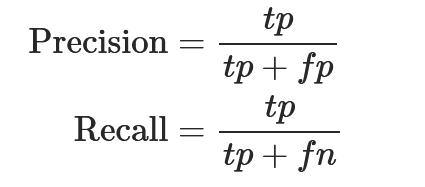

Fonction qui optimise Precision et Recall avec une importance plus forte pour le critère Precision: 
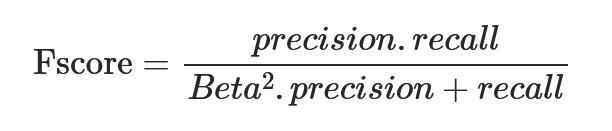
Avec Beta le coefficient d'importance relative au critère Precision par rapport au recall : 
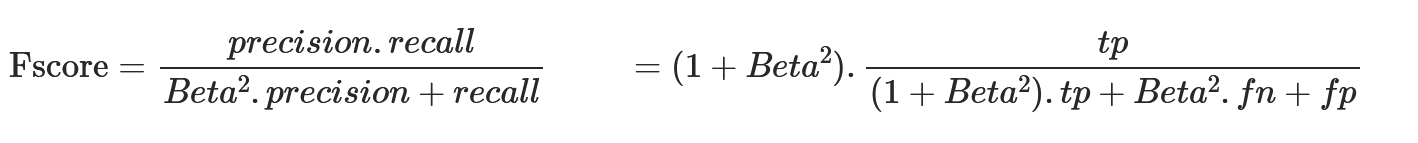

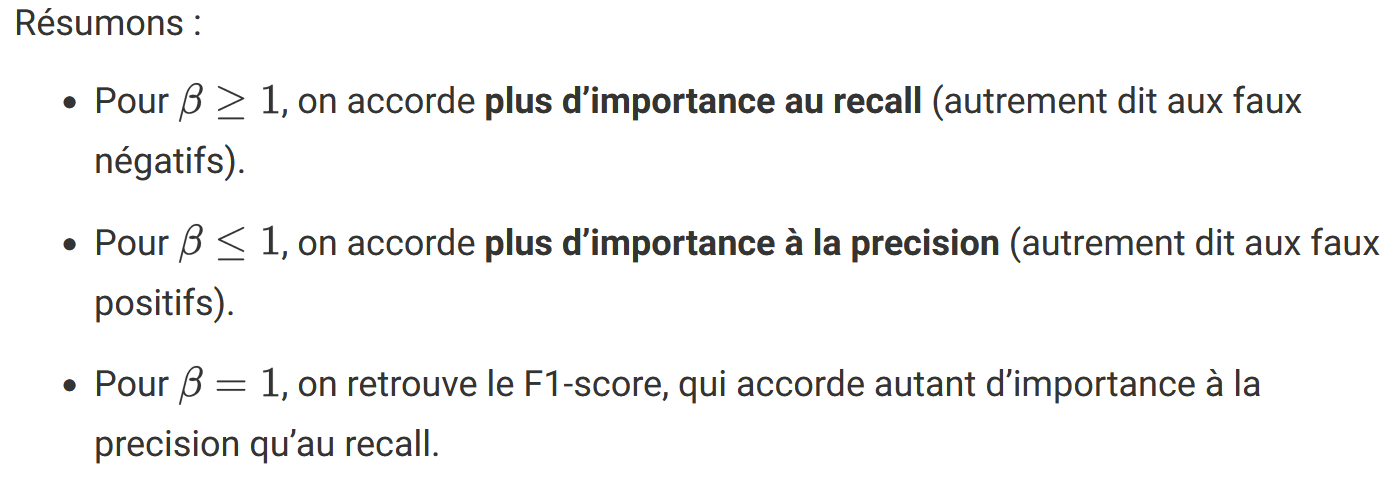
- Pour Beta >= 1 , on accorde plus d’importance au recall (autrement dit aux faux négatifs).
- Pour Beta <= 1, on accorde plus d’importance à la precision (autrement dit aux faux positifs).
- Pour Beta = 1, on retrouve le F1-score, qui accorde autant d’importance à la precision qu’au recall.




Le F1-score étant une moyenne harmonique de la précision et du recall, il n’est élevé qu’à condition que ces deux indicateurs soient élevés. Il traduit donc bien un compromis entre precision et recall. Lorsque le recall baisse par exemple, le terme augmente fortement et le F1-score diminue.

L'application de cette métrique métier passe par la quantification de l'importance relative entre recall et précision, à savoir Beta (β). Cela revient à estimer le coût moyen d'un défaut, et le coût d'opportunité d'un client refusé par erreur. Cette connaissance métier n'est pas évoquée à ce stade du projet, nous allons donc l'estimer. Cette hypothèse pourra bien entendu être modifiée avec un interlocuteur métier.

Défaut de paiement 60% du montant du crédit en pertes et autres frais de recouvrement.
10% de chance d'obtenir un crédit pour un client lambda qui souhaite emprunter.

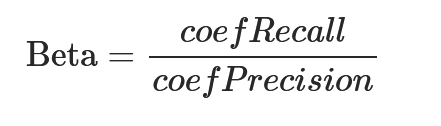

https://en.wikipedia.org/wiki/Precision_and_recall

In [15]:
data_train_T.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_0,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [16]:
data_test_T.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_0,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [17]:

data_test_T.astype('int8').dtypes

SK_ID_CURR                         int8
TARGET                             int8
CNT_CHILDREN                       int8
AMT_INCOME_TOTAL                   int8
AMT_CREDIT                         int8
                                   ... 
WALLSMATERIAL_MODE_Stone, brick    int8
WALLSMATERIAL_MODE_Wooden          int8
EMERGENCYSTATE_MODE_0              int8
EMERGENCYSTATE_MODE_No             int8
EMERGENCYSTATE_MODE_Yes            int8
Length: 320, dtype: object

In [18]:
data_train_T = data_train_T.astype('int8')

In [19]:
data_test_T = data_test_T.astype('int8')

In [20]:
data_train_T = data_train_T.head(100000)
data_test_T = data_test_T.head(15000)

In [21]:
import re
data_train_T = data_train_T.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
data_test_T = data_test_T.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

In [22]:

f_score = dict()
lim = dict()
feats = [f for f in data_train_T.columns if f not in [
    'TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]
np.savetxt("feats.csv", np.atleast_2d(feats), fmt="%s", delimiter=",")


In [23]:
data_train_T.dtypes

SK_ID_CURR                       int8
TARGET                           int8
CNT_CHILDREN                     int8
AMT_INCOME_TOTAL                 int8
AMT_CREDIT                       int8
                                 ... 
WALLSMATERIAL_MODE_Stonebrick    int8
WALLSMATERIAL_MODE_Wooden        int8
EMERGENCYSTATE_MODE_0            int8
EMERGENCYSTATE_MODE_No           int8
EMERGENCYSTATE_MODE_Yes          int8
Length: 320, dtype: object

In [80]:
#Permet de produire la courbe du fbeta score
def fbscore (X, y, beta = 1):
    
    pre, rec, thresh = precision_recall_curve(X, y)
    pre = pre[:-1]
    rec = rec[:-1]
    
    b2 = beta**2
    temp = pd.DataFrame(pre, columns=["pre"])
    temp["rec"] = rec
    temp["fb"] = ((1 + b2)*(temp["pre"] * temp["rec"]))/(b2 * temp["pre"] + temp["rec"])
    temp["fb"].fillna(0, inplace=True)
    fb = temp["fb"].to_numpy()
    
    return fb, thresh



In [81]:
# D'après la courbe du fbeta score, classe les éléments dans une ou l'autre catégorie selon la 
# probabilité correspondant au fbeta score maximal
def classifier (target, fbtab, thresh):
    lim = thresh[np.argmax(fbtab)]
    tab_class = (target > lim).astype(int)
    return tab_class, lim

In [82]:
# met en forme les parametres de sortie du grid-search du pipeline pour être compatible avec l'algorithme 
def best_params(gs):
    dic = gs.best_params_
    a = list(dic.keys())
    temp = pd.Series(list(dic.keys()))
    b = temp.str.split("__").str[1].to_numpy()
    for i in range(len(a)):
        dic[b[i]] = dic.pop(a[i])
    return dic

### LGBMClassifier

In [83]:
def lightgbm(num_folds, beta = 1, grid_search = True):
    
    
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(data_train_T.shape, data_test_T.shape))
    
    if grid_search :
        over = SMOTE(sampling_strategy=0.2)
        under = RandomUnderSampler(sampling_strategy = 0.5)
        clf = LGBMClassifier()
        steps = [("over", over), ("under", under), ("model", clf)]
        LGBM_pipe = Pipeline(steps=steps)

        params = [{"model__n_estimators" : [100, 1000, 10000],
                  "model__learning_rate" : [0.001, 0.01, 0.1], 
                  "model__num_leaves" : [20, 30, 40]}]

        
        gs_LGBM = GridSearchCV(LGBM_pipe,
                              param_grid = params,
                               scoring = "roc_auc",
                               cv=5)

        gs_LGBM.fit(data_train_T[feats], data_train_T['TARGET'])
        params = best_params(gs_LGBM)
        print(params)
    else :
        params = {'learning_rate': 0.01, 'n_estimators': 1000, 'num_leaves': 20}
         #'num_leaves': 60, 'n_estimators': 150, 'learning_rate': 0.2
    # Divide in training/validation and test data

    folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001) #Nbr folds à modifier
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(data_train_T.shape[0])
    sub_preds = np.zeros(data_test_T.shape[0])
    feature_importance_df = pd.DataFrame()



    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(data_train_T[feats], data_train_T['TARGET'])):
        train_x, train_y = data_train_T[feats].iloc[train_idx], data_train_T['TARGET'].iloc[train_idx]
        valid_x, valid_y = data_train_T[feats].iloc[valid_idx], data_train_T['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        over = SMOTE(sampling_strategy=0.3)
        under = RandomUnderSampler(sampling_strategy = 0.5)
        clf = LGBMClassifier(**params)

        steps = [("over", over), ("under", under), ("model", clf)]
        pipeline = Pipeline(steps=steps)
    #     print(np.any(np.isnan(train_df)))
    #     print(np.all(np.isfinite(train_df)))
    #     print(np.any(np.isnan(test_df)))
    #     print(np.all(np.isfinite(test_df)))
        pipeline.fit(train_x, train_y, model__eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            model__eval_metric= "auc", model__verbose= 200, model__early_stopping_rounds= 200)

        oof_preds[valid_idx] = pipeline.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += pipeline.predict_proba(data_test_T[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
        


        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        

        
        del clf, train_x, train_y, valid_x, valid_y, pipeline
        
    fb_lgbm, thresh = fbscore(data_train_T["TARGET"], oof_preds, beta)
    print ("F-{} score max : {}".format(beta, np.max(fb_lgbm)))
    data_test_T["TARGET LGBM"], lim["LGBM"] = classifier(sub_preds, fb_lgbm, thresh)
    data_test_T["TARGET LGBM score"] = sub_preds
    
  
    return feature_importance_df, np.max(fb_lgbm), oof_preds, params

In [28]:
from sklearn.metrics import precision_recall_curve

In [84]:
feature_imp_lgbm, f_score["LGBM"], pred_train, params_lgbm = lightgbm(num_folds = 6, beta = 0.1, grid_search=False)


Starting LightGBM. Train shape: (100000, 320), test shape: (15000, 322)
[200]	valid_0's auc: 0.626846	valid_0's binary_logloss: 0.378411	valid_1's auc: 0.617736	valid_1's binary_logloss: 0.381603
[400]	valid_0's auc: 0.640473	valid_0's binary_logloss: 0.337116	valid_1's auc: 0.624556	valid_1's binary_logloss: 0.342028
[600]	valid_0's auc: 0.647438	valid_0's binary_logloss: 0.317628	valid_1's auc: 0.627497	valid_1's binary_logloss: 0.323833
[800]	valid_0's auc: 0.655038	valid_0's binary_logloss: 0.306712	valid_1's auc: 0.630624	valid_1's binary_logloss: 0.314416
[1000]	valid_0's auc: 0.663123	valid_0's binary_logloss: 0.300767	valid_1's auc: 0.633388	valid_1's binary_logloss: 0.309855
[200]	valid_0's auc: 0.631596	valid_0's binary_logloss: 0.378324	valid_1's auc: 0.609911	valid_1's binary_logloss: 0.378195
[400]	valid_0's auc: 0.642097	valid_0's binary_logloss: 0.339193	valid_1's auc: 0.616048	valid_1's binary_logloss: 0.339565
[600]	valid_0's auc: 0.649437	valid_0's binary_logloss: 0.3

In [85]:
data_test_T["TARGET LGBM"].value_counts()

0    14908
1       92
Name: TARGET LGBM, dtype: int64

Text(0.5, 1.0, 'Credit acceptation repartition')

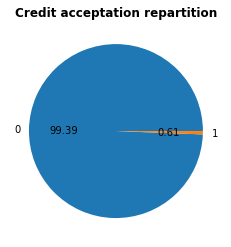

In [86]:
plt.figure()
plt.pie(data_test_T["TARGET LGBM"].value_counts(), 
        labels=data_test_T["TARGET LGBM"].value_counts().index, 
        autopct="%.2f")
plt.title("Credit acceptation repartition", weight="bold")

### Sauvegarde des prédictions

In [88]:
# Sauvegarde des prédictions
data_test_T.to_csv("app_test.csv")


### préparation à l'API

Text(0.5, 1.0, "fbeta score selon l'algorithme")

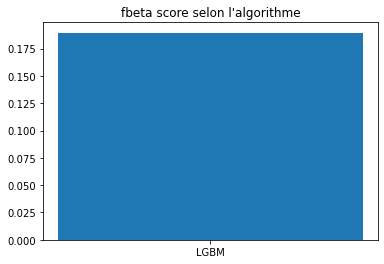

In [89]:
plt.bar(f_score.keys(), f_score.values())
plt.title("fbeta score selon l'algorithme")

In [90]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresh2 = roc_curve(data_train_T["TARGET"], pred_train)
auc = roc_auc_score(data_train_T["TARGET"], pred_train)

In [91]:
fbres, thresh = fbscore(data_train_T["TARGET"], pred_train, 0.1)
prec, rec, _ = precision_recall_curve(data_train_T["TARGET"], pred_train)

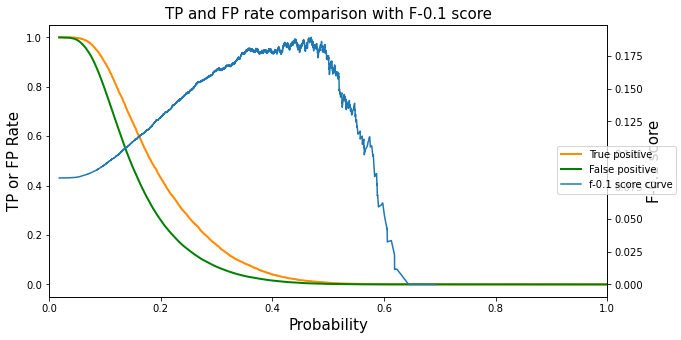

In [92]:
fig = plt.figure(1, figsize=(10, 5))
#fig = plt.figure(figsize=(20,15))
  
ax1 = plt.subplot()
#fig, ax1 = plt.subplots()
lw = 2
ax1.plot(
    thresh2,
    tpr,
    color="darkorange",
    lw=lw,
    label="True positive" % auc,
)
ax1.plot(
    thresh2,
    fpr,
    color="green",
    lw=lw,
    label="False positive" % auc,
)

ax1.set_xlabel("Probability",fontsize = 15)
ax1.set_ylabel("TP or FP Rate", fontsize = 15)
ax1.set_xlim([0,1])

ax2 = ax1.twinx()
ax2.plot(
    thresh,
    fbres,
    label="f-0.1 score curve")
ax2.set_ylabel("F-0.1 score",fontsize = 15)


ax1.set_title("TP and FP rate comparison with F-0.1 score", fontsize = 15)
fig.legend(loc = 'right')
fig.show()

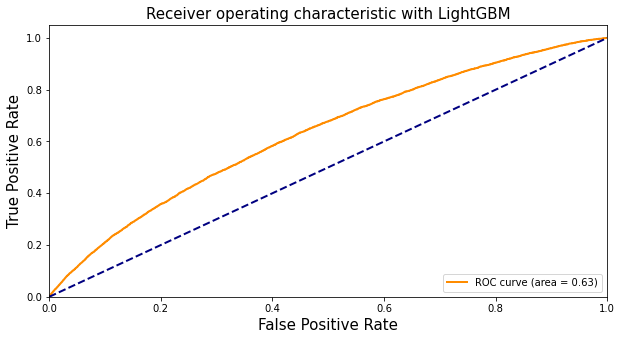

In [93]:
fig = plt.figure(1, figsize=(10, 5))

lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize = 15)
plt.ylabel("True Positive Rate", fontsize = 15)
plt.title("Receiver operating characteristic with LightGBM", fontsize = 15)
plt.legend(loc="lower right")
plt.show()

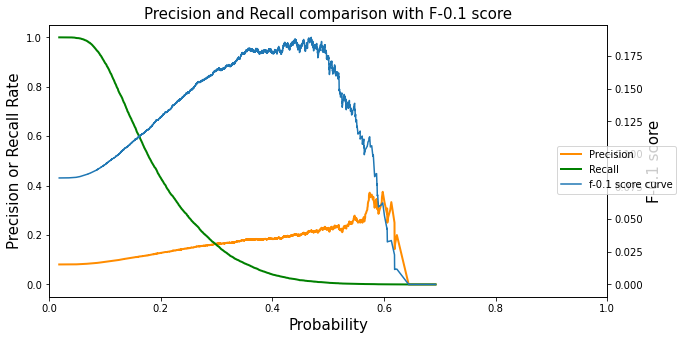

In [94]:
fig = plt.figure(1, figsize=(10, 5))
ax1 = plt.subplot()
#fig, ax1 = plt.subplots()
lw = 2
ax1.plot(
    thresh,
    prec[:-1],
    color="darkorange",
    lw=lw,
    label="Precision" % auc,
)
ax1.plot(
    thresh,
    rec[:-1],
    color="green",
    lw=lw,
    label="Recall" % auc,
)

ax1.set_xlabel("Probability" ,fontsize = 15)
ax1.set_ylabel("Precision or Recall Rate",fontsize = 15)
ax1.set_xlim([0,1])

ax2 = ax1.twinx()
ax2.plot(
    thresh,
    fbres,
    label="f-0.1 score curve" )
ax2.set_ylabel("F-0.1 score",fontsize = 15)


ax1.set_title("Precision and Recall comparison with F-0.1 score",fontsize = 15)
fig.legend(loc="right")
fig.show()

In [95]:
over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy = 0.5)
clf = LGBMClassifier(**params_lgbm)

steps = [("over", over), ("under", under), ("model", clf)]
pipeline = Pipeline(steps=steps)

pipeline.fit(data_train_T[feats], data_train_T["TARGET"])

Pipeline(steps=[('over', SMOTE(sampling_strategy=0.2)),
                ('under', RandomUnderSampler(sampling_strategy=0.5)),
                ('model',
                 LGBMClassifier(learning_rate=0.01, n_estimators=1000,
                                num_leaves=20))])

### Importance des features globale

In [96]:
fi = pd.DataFrame()

In [97]:
fi["importances"] = clf.feature_importances_

In [98]:
fi["features"] = feats

In [99]:
fi.sort_values(by=["importances"], ascending=False, inplace=True)

Text(0.5, 1.0, 'Feature importances')

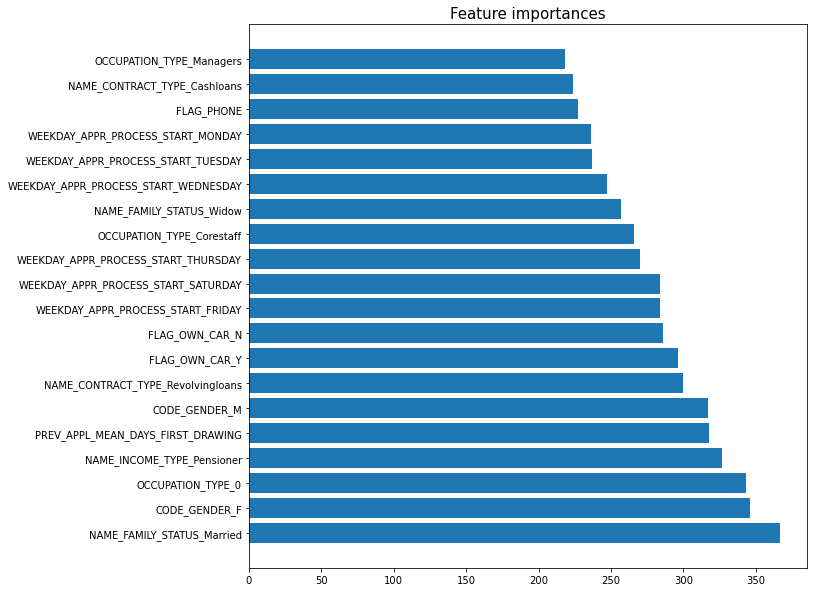

In [43]:
fig = plt.figure(figsize=(10,10))
plt.barh(fi["features"][:20], fi["importances"][:20])
plt.title("Feature importances", fontsize = 15)

In [102]:


def plot_feature_importances(df):

    
    # Sort features according to importance
    df = fi.sort_values('importances', ascending=False)
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importances'] / df['importances'].sum()
    
    return df



In [103]:
plot_feature_importances(feats)

,importances,features,importance_normalized
177,334,CODE_GENDER_F,0.017579
214,328,OCCUPATION_TYPE_0,0.017263
204,321,NAME_FAMILY_STATUS_Married,0.016895
176,310,NAME_CONTRACT_TYPE_Revolvingloans,0.016316
178,299,CODE_GENDER_M,0.015737
...,...,...,...
80,0,FLAG_DOCUMENT_4,0.000000
83,0,FLAG_DOCUMENT_7,0.000000
86,0,FLAG_DOCUMENT_10,0.000000
49,0,ELEVATORS_MODE,0.000000


## Analyase locale 
### Importance des features pour un client spécifique 

In [144]:
#SHAP (SHapley Additive exPlanations) est une approche unifiée pour expliquer la sortie de tout modèle d'apprentissage automatique. SHAP relie la théorie des jeux aux explications locales, unissant plusieurs méthodes précédentes et représentant la seule méthode d'attribution de caractéristiques additives cohérente et localement précise possible basée sur les attentes.

In [127]:
data_test_T[feats].columns

Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       ...
       'WALLSMATERIAL_MODE_Block', 'WALLSMATERIAL_MODE_Mixed',
       'WALLSMATERIAL_MODE_Monolithic', 'WALLSMATERIAL_MODE_Others',
       'WALLSMATERIAL_MODE_Panel', 'WALLSMATERIAL_MODE_Stonebrick',
       'WALLSMATERIAL_MODE_Wooden', 'EMERGENCYSTATE_MODE_0',
       'EMERGENCYSTATE_MODE_No', 'EMERGENCYSTATE_MODE_Yes'],
      dtype='object', length=318)

In [139]:
X_test_data_frame = pd.DataFrame(data_test_T, columns=data_test_T[feats].columns, index=data_test_T.index)
X_test_data_frame

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,WALLSMATERIAL_MODE_Stonebrick,WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_0,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
14996,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
14997,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
14998,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [140]:
lime1 = LimeTabularExplainer(X_test_data_frame,
                             feature_names=X_test_data_frame.columns,
                             class_names=["Solvable", "Non Solvable"],
                             discretize_continuous=False)



In [141]:
exp = lime1.explain_instance(X_test_data_frame.iloc[100],
                             clf.predict_proba,
                             num_samples=100)


In [143]:
# Id client
X_test_data_frame.index[100]


100

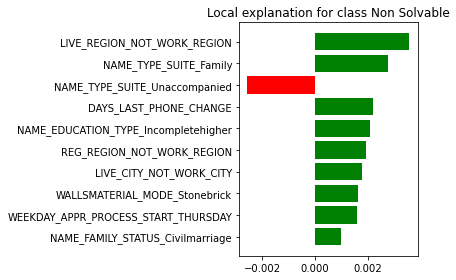

In [142]:


# Affichage des résultats
exp.show_in_notebook(show_table=False)

exp.as_pyplot_figure()
plt.tight_layout()




- La  solvabilité du client '100' est supérieur au seuil de non solvabilité, donc le client est solvable. 
- La variable qui joue le plus en sa défaveur est 'Name_Type_suite_unaccompanied'.
- La variable qui joue le plus en sa faveur est 'LIVE_REGION_NOT_WORK_REGION'.

In [ ]:
# !pip install shap

In [44]:
#import shap
#import joblib
#shap.initjs()

#explainer = shap.TreeExplainer(clf)
#joblib.dump(explainer, "shap_explainer.joblib")
#shap_values = explainer.shap_values(data_test_T[feats])
#shap.summary_plot(shap_values[1], data_test_T[feats], plot_type='bar')